In [1]:
import logging

import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import anndata
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
from skimage.measure import regionprops
from skimage.segmentation import find_boundaries
from scipy.stats import ttest_ind

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from mip.utils import extract_ome_tiff, create_circular_mask
from mip.spatial_features import get_spatial_features

In [3]:
# read in object with neighborhood/cell type metadata
adata = sc.read_h5ad('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/downstream_analysis/neighborhood_analysis.h5ad')
adata

AnnData object with n_obs × n_vars = 221081 × 17
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3 intensity max', 'CD36 intensity max', 'HIF1a intensity max', 'GLUT1 intensity max', 'GATA3 intensity max', 'CD45RO intensity max', 'CD45RA intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'Maspin intensity max', 'Foxp3 intensity max', 'MMP9 intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'CD44 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min

In [4]:
adata.obs

,area,perimeter,bbox_row_min,bbox_col_min,bbox_row_max,bbox_col_max,centroid_row,centroid_col,eccentricity,DAPI intensity max,...,CK14 intensity min,CD11c intensity min,CD44 intensity min,leiden,cell type,cell_type,centroid_row_inverted,LDA_kmeans_cluster,max_theme,metacluster
cell_id,,,,,,,,,,,,,,,,,,,,,
1,520,110.840620,0,3673,25,3709,8.378846,3693.750000,0.723583,49006.0,...,1547.0,404.0,38.0,6,Malignant,Malignant,-8.378846,1,7,Tumor - Pure
2,409,98.704581,0,3711,26,3740,8.728606,3722.951100,0.452175,44971.0,...,4518.0,61.0,29.0,6,Malignant,Malignant,-8.728606,1,7,Tumor - Pure
3,845,150.675144,0,3739,32,3776,13.584615,3755.928994,0.368285,49170.0,...,8671.0,21.0,71.0,6,Malignant,Malignant,-13.584615,1,7,Tumor - Pure
4,241,70.870058,0,3873,12,3902,4.082988,3886.991701,0.928244,49978.0,...,56332.0,283.0,95.0,6,Malignant,Malignant,-4.082988,1,7,Tumor - Pure
5,733,115.639610,0,3888,35,3921,16.049113,3906.064120,0.497079,59773.0,...,4903.0,65.0,66.0,6,Malignant,Malignant,-16.049113,1,7,Tumor - Pure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221077,340,80.970563,15108,10235,15120,10268,15114.164706,10249.664706,0.935688,26368.0,...,1728.0,46.0,636.0,10,Macrophage,Macrophage,-15114.164706,10,7,Tumor - Pure
221078,162,62.248737,15107,9158,15120,9182,15115.290123,9168.080247,0.861327,44711.0,...,52670.0,445.0,910.0,1,Malignant,Malignant,-15115.290123,1,7,Tumor - Pure
221079,35,24.485281,15116,9213,15120,9224,15117.828571,9218.000000,0.938642,33583.0,...,13957.0,810.0,507.0,0,Malignant,Malignant,-15117.828571,1,7,Tumor - Pure


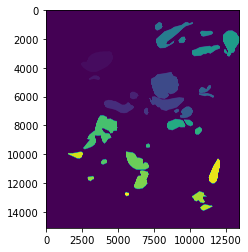

In [5]:
ome_fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/level_2/HT206B1-H1.ome.tiff'
label_fp = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/level_3/annotations/dcis.tif'
mask = tifffile.imread(label_fp)
plt.imshow(mask)

In [6]:
region_ids = np.unique(mask)
len(region_ids), region_ids[:10]

(32,
 array([   0,  257,  514,  771, 1028, 1285, 1542, 1799, 2056, 2313],
       dtype=uint16))

In [7]:
df = get_spatial_features(label_fp, ome_fp)
df.index.name = 'region_id'
df

,area,perimeter,bbox_row_min,bbox_col_min,bbox_row_max,bbox_col_max,centroid_row,centroid_col,eccentricity,DAPI intensity max,...,CK19 intensity min,MGP intensity min,Vimentin intensity min,Maspin intensity min,Foxp3 intensity min,MMP9 intensity min,HLA-DR intensity min,CK14 intensity min,CD11c intensity min,CD44 intensity min
region_id,,,,,,,,,,,,,,,,,,,,,
257,2147719,6102.149996,2851,2428,4296,4633,3562.477546,3605.399579,0.835117,65085.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
514,163811,1965.682466,4531,2959,4854,3739,4696.445172,3384.469663,0.924486,60502.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
771,238408,1909.942351,5664,5797,6179,6415,5920.164286,6082.538375,0.528736,59522.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1028,1116482,5291.300141,6231,4026,7151,6113,6684.306454,5034.598675,0.947850,61321.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285,118511,1359.182900,6765,6790,7261,7103,7018.667212,6953.058071,0.757520,58244.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1542,1441764,6653.110458,5981,7158,6996,9595,6440.878748,8369.379181,0.930161,62872.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1799,2587527,6596.292132,4288,7279,6154,9197,5192.546956,8224.442569,0.440083,63388.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2056,68383,1085.129076,6846,8878,7137,9246,6992.283623,9050.610269,0.757019,63150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2313,496348,3000.332357,6684,9307,7486,10198,7094.836232,9745.010158,0.679063,64237.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
region_to_cell_ids = {}
for cell_id, r, c in zip(adata.obs.index, adata.obs['centroid_row'], adata.obs['centroid_col']):
    region_id = mask[int(r), int(c)]
    if region_id:
        if str(region_id) not in region_to_cell_ids:
            region_to_cell_ids[str(region_id)] = [cell_id]
        else:
            region_to_cell_ids[str(region_id)].append(cell_id)
cell_id_to_region_id = {v:k for k, vs in region_to_cell_ids.items() for v in vs}
adata.obs['dcis_region_id'] = [cell_id_to_region_id.get(cid) for cid in adata.obs.index]
adata.uns['dcis_region_to_cell_ids'] = region_to_cell_ids
adata.uns['dcis_region_spatial_features'] = df

In [9]:
# annotate adata object with dcis information
def get_tumor_type(region_id, ct):
    if ct == 'Malignant' and not pd.isnull(region_id):
        return 'DCIS'
    elif ct == 'Malignant':
        return 'IDC'
    return None

adata.obs['tumor_type'] = [get_tumor_type(rid, ct)
                               for rid, ct in zip(adata.obs['dcis_region_id'], adata.obs['cell_type'])]

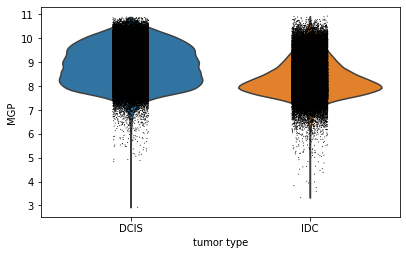

In [10]:
sc.pl.violin(adata, keys=['MGP'], groupby='tumor_type')

DAPI 0.0


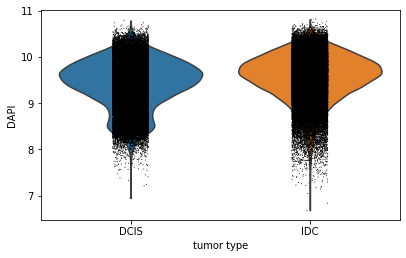

CD31 0.0


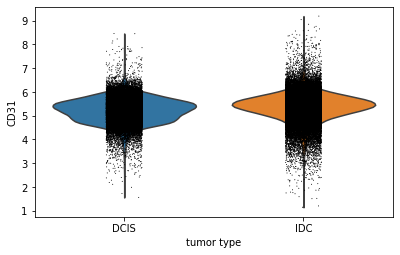

E-cadherin 6.720420721641184e-21


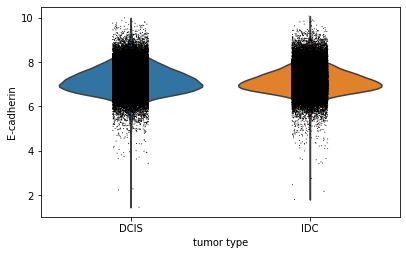

CD4 0.0


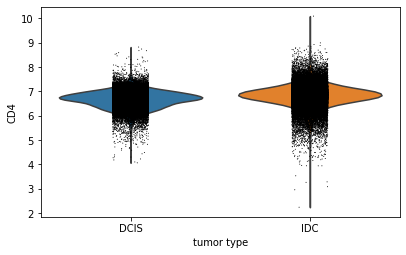

CD20 3.037579745858534e-114


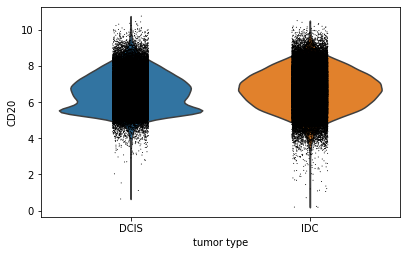

Ki67 0.0


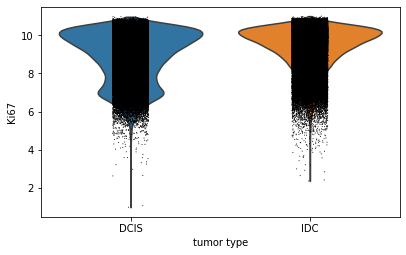

CD68 1.5636538184774779e-43


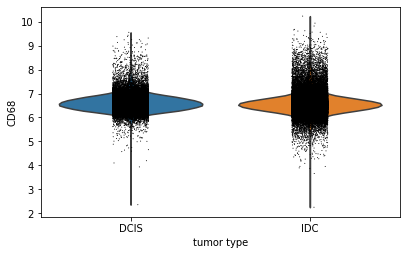

Pan-CK 7.68819297558482e-15


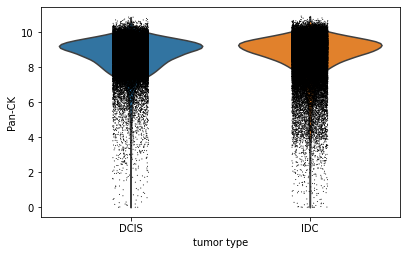

CD8 0.30658869126155575


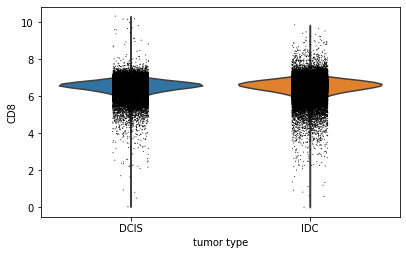

Histone H3 Pho 0.0


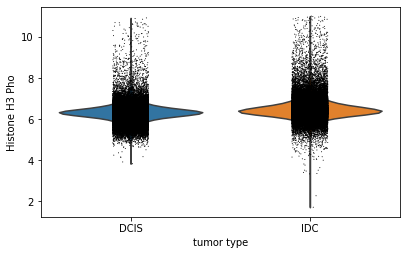

CD163 0.0


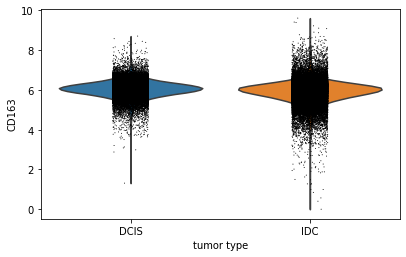

Podoplanin 1.3547308169472609e-40


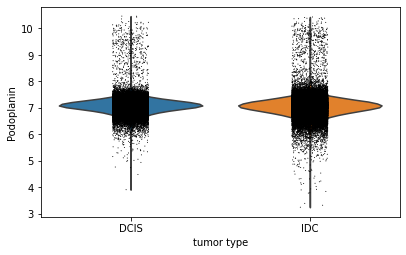

CD3 0.0


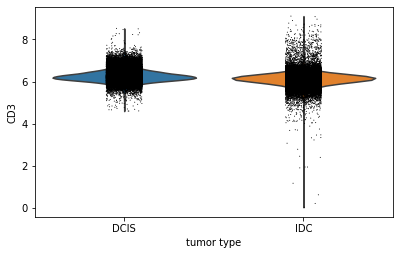

CD36 0.0


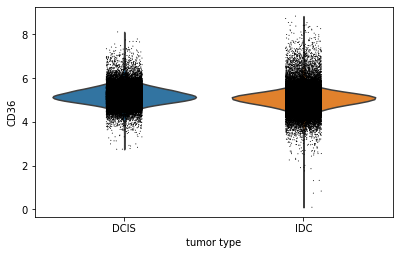

HIF1a 0.0011168383880630877


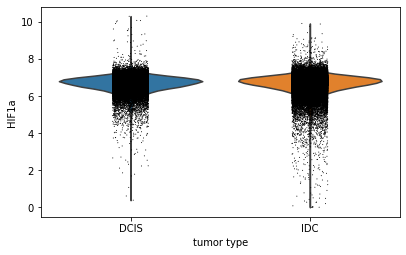

GLUT1 0.0


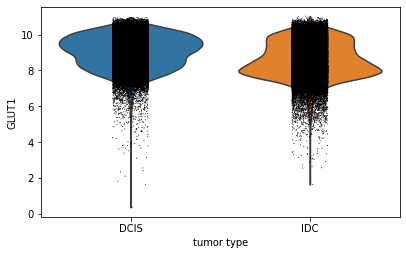

GATA3 2.3126614312286173e-17


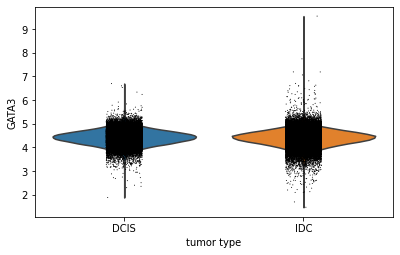

CD45RO 5.936655483801807e-35


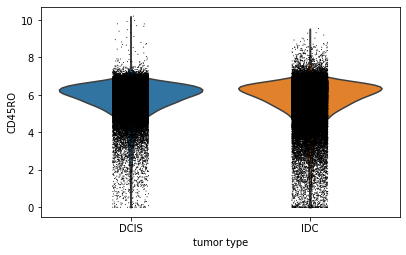

CD45RA 3.756336978866011e-130


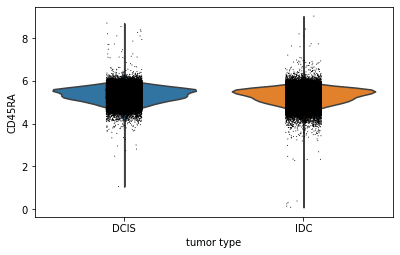

SMA 2.9206575768981995e-63


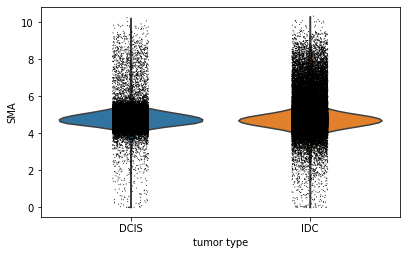

CK19 3.037904243592173e-49


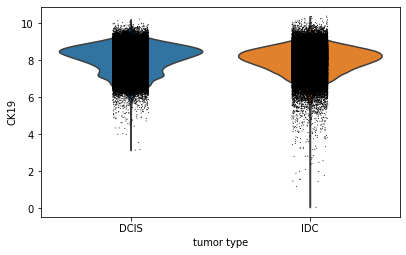

MGP 0.0


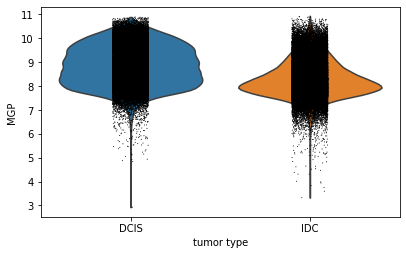

Vimentin 3.333297964771443e-162


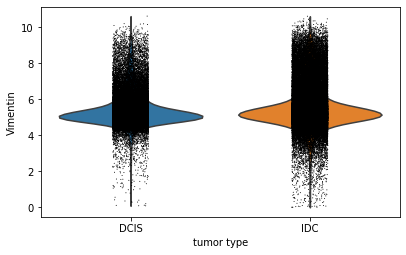

Maspin 0.0


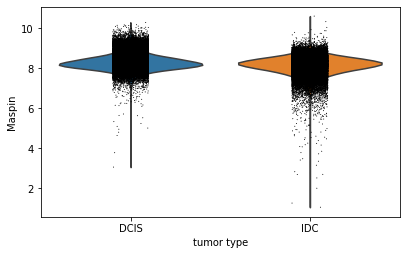

Foxp3 0.0


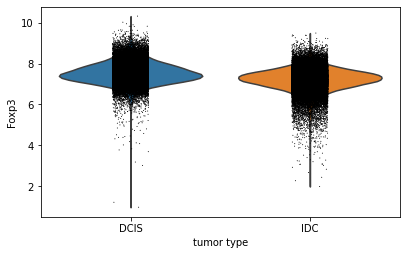

MMP9 0.0


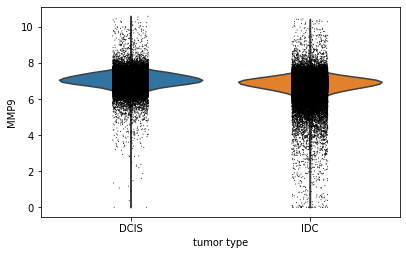

HLA-DR 5.063471898118883e-138


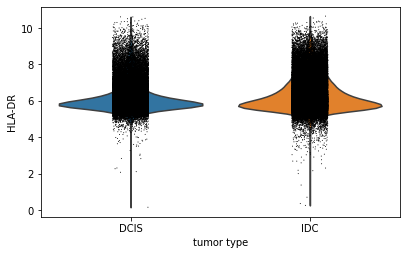

CK14 0.0


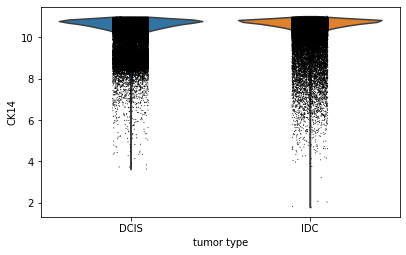

CD11c 1.9220816977015518e-31


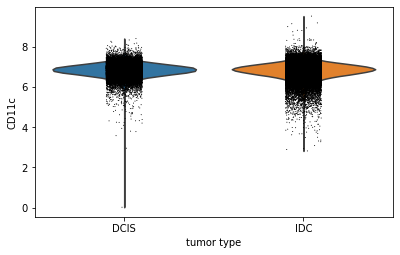

CD44 0.0


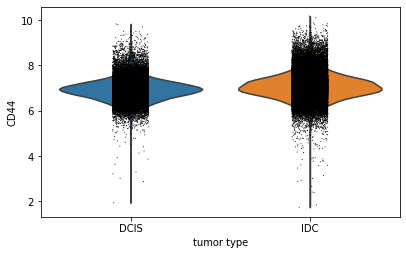

In [11]:
for v in adata.raw.var.index:
    xs = adata.raw[adata.obs['tumor_type']=='DCIS', [v]].X.flatten()
    ys = adata.raw[adata.obs['tumor_type']=='IDC', [v]].X.flatten()
    p = ttest_ind(xs, ys)[1]
    print(v, p)
    sc.pl.violin(adata, keys=v, groupby='tumor_type', use_raw=True)
    plt.show()

In [12]:
def get_region_label(region_id, ct):
    if ct == 'Malignant' and not pd.isnull(region_id):
        return region_id
    elif ct == 'Malignant':
        return 'IDC'
    return 'Background (non-tumor)'

adata.obs['DCIS_region_label'] = [get_region_label(rid, ct)
                                  for rid, ct in zip(adata.obs['dcis_region_id'], adata.obs['cell_type'])]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'IDC'),
  Text(1, 0, 'Background (non-tumor)'),
  Text(2, 0, '3084'),
  Text(3, 0, '3341'),
  Text(4, 0, '4369'),
  Text(5, 0, '3855'),
  Text(6, 0, '3598'),
  Text(7, 0, '4112'),
  Text(8, 0, '257'),
  Text(9, 0, '1799'),
  Text(10, 0, '514'),
  Text(11, 0, '2570'),
  Text(12, 0, '771'),
  Text(13, 0, '2827'),
  Text(14, 0, '1542'),
  Text(15, 0, '1028'),
  Text(16, 0, '2313'),
  Text(17, 0, '1285'),
  Text(18, 0, '2056'),
  Text(19, 0, '5654'),
  Text(20, 0, '4883'),
  Text(21, 0, '4626'),
  Text(22, 0, '5140'),
  Text(23, 0, '5397'),
  Text(24, 0, '6168'),
  Text(25, 0, '7453'),
  Text(26, 0, '7710'),
  Text(27, 0, '5911'),
  Text(28, 0, '6425'),
  Text(29, 0, '6682'),
  Text(30, 0, '6939'),
  Text(31, 0, '7967'),
  Text(32, 0, '7196')])

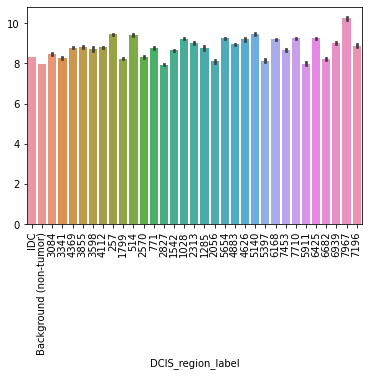

In [13]:
mgp = adata.raw[:, ['MGP']].X.flatten()
sns.barplot(data=adata.obs, x='DCIS_region_label', y=mgp)
plt.xticks(rotation=90)

In [14]:
def region_barplot(adata, marker, ylim=None):
    mgp = adata.raw[:, [marker]].X.flatten()
    ax = sns.barplot(data=adata.obs, x='dcis_region_id', y=mgp, color=sns.color_palette()[0])
    idc_avg = np.mean(adata.raw[adata.obs['DCIS_region_label']=='IDC', [marker]].X)
    back_avg = np.mean(adata.raw[adata.obs['DCIS_region_label']=='Background (non-tumor)', [marker]].X)
    plt.xticks(rotation=90)
    plt.axhline(y=idc_avg, color=sns.color_palette()[1], linestyle='dashed', label='IDC')
    plt.axhline(y=back_avg, color=sns.color_palette()[2], linestyle='dashed', label='Background (non-tumor)')
    if ylim is not None:
        plt.ylim(ylim)
    plt.legend()

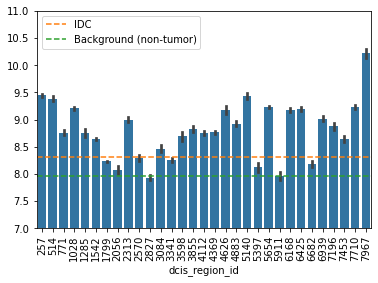

In [15]:
region_barplot(adata, 'MGP', ylim=(7, 11))

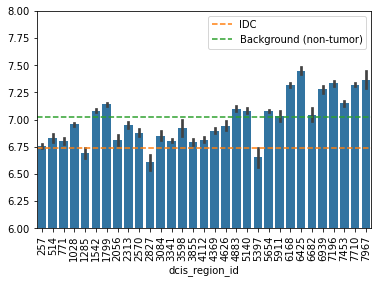

In [16]:
region_barplot(adata, 'MMP9', ylim=(6, 8))

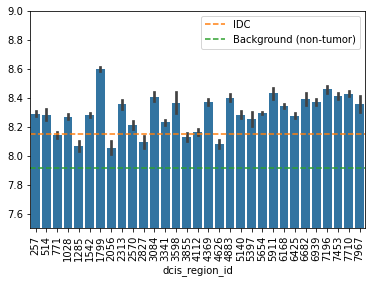

In [17]:
region_barplot(adata, 'Maspin', ylim=(7.5, 9))

In [18]:
def get_cell_label(region_id, ct):
    if ct == 'Malignant' and not pd.isnull(region_id):
        return 'Malignant - DCIS'
    elif ct == 'Malignant':
        return 'Malignant - IDC'
    return ct

adata.obs['cell_type_v2'] = [get_cell_label(rid, ct)
                                  for rid, ct in zip(adata.obs['dcis_region_id'], adata.obs['cell_type'])]

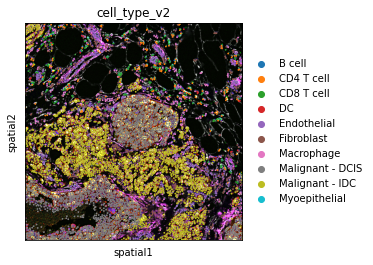

In [19]:
sc.pl.spatial(adata, color='cell_type_v2', crop_coord=[5000, 7000, 5000, 7000], size=.8)

In [20]:
sq.gr.interaction_matrix(adata, cluster_key="cell_type_v2")

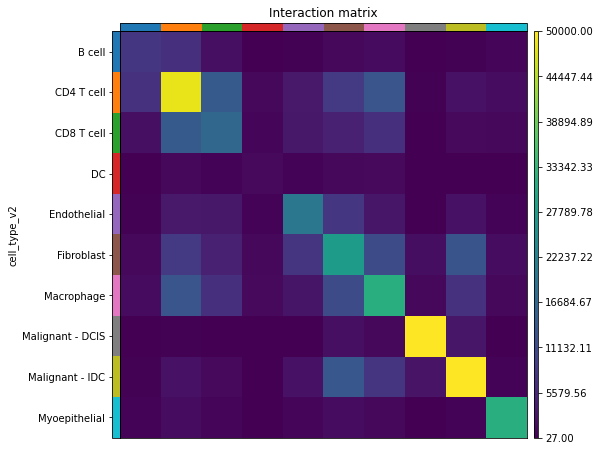

In [21]:
sq.pl.interaction_matrix(adata, cluster_key="cell_type_v2", vmax=50000)

In [22]:
sq.gr.interaction_matrix(adata, cluster_key="metacluster")

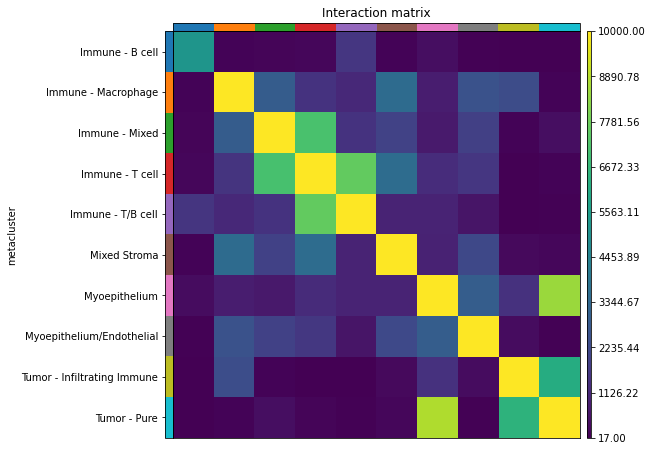

In [23]:
sq.pl.interaction_matrix(adata, cluster_key="metacluster", vmax=10000)

In [24]:
def get_cell_label(region_id, ct, meta):
    if 'Tumor' in meta and not pd.isnull(region_id):
        return 'Malignant - DCIS'
    elif 'Tumor' in meta:
        return 'Malignant - IDC'
    return meta

adata.obs['dcis_metacluster'] = [get_cell_label(rid, ct, meta)
                                  for rid, ct, meta in zip(adata.obs['dcis_region_id'], adata.obs['cell_type'], adata.obs['metacluster'])]

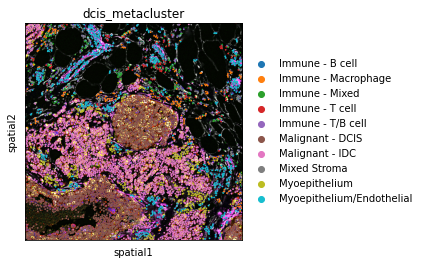

In [25]:
sc.pl.spatial(adata, color='dcis_metacluster', crop_coord=[5000, 7000, 5000, 7000], size=.8)

In [26]:
sq.gr.interaction_matrix(adata, cluster_key="dcis_metacluster")

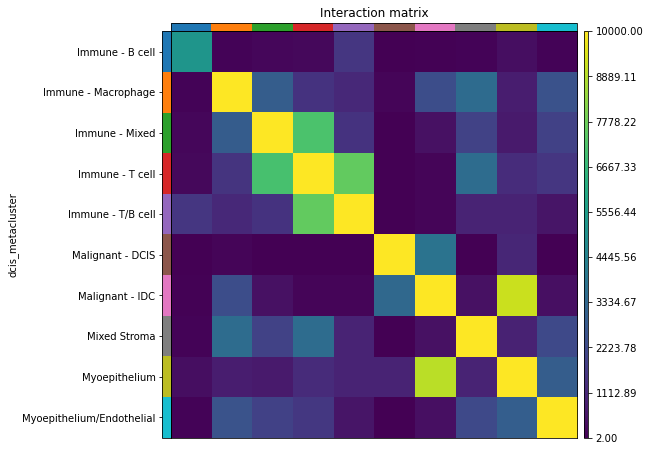

In [27]:
sq.pl.interaction_matrix(adata, cluster_key="dcis_metacluster", vmax=10000)

In [28]:
# pick out edge cells
# for every dcis region
# pick out malignant cells within 50 pixels of boundary


In [31]:
def get_edge_cells(adata, region_img, cell_type=None, cell_type_col=None, radius=50):
    region_ids = np.unique(region_img)[1:]
    boundaries = find_boundaries(region_img)
    edge_cells = []
    for cell_id, r, c in zip(adata.obs.index, adata.obs['centroid_row'], adata.obs['centroid_col']):
        r, c = int(r), int(c)
        bbox = boundaries[max(0, r - radius):r + radius, max(0, c - radius):c + radius]
        circle = create_circular_mask(bbox.shape[0], bbox.shape[1], center=(radius, radius), radius=radius)
        if np.sum(bbox[circle]):
            edge_cells.append(cell_id)
    
    if cell_type is not None:
        edge_cells = [c for c in edge_cells if adata.obs.loc[c, cell_type_col]==cell_type]
    
    return edge_cells

In [37]:
dcis_edge_cells = get_edge_cells(adata, mask, cell_type='Malignant - DCIS', cell_type_col='dcis_metacluster',
                                radius=25)
len(dcis_edge_cells)

4937

In [38]:
pool = set(dcis_edge_cells)
adata.obs['is_dcis_edge_cell'] = ['Edge' if c in pool else 'Not Edge' for c in adata.obs.index]

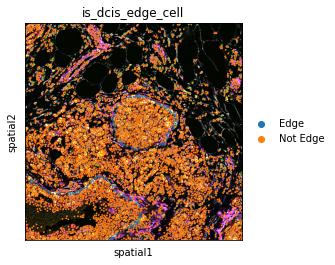

In [39]:
sc.pl.spatial(adata, color='is_dcis_edge_cell', crop_coord=[5000, 7000, 5000, 7000], size=.8)

In [41]:
def get_metacluster_label(region_id, e, meta):
    if 'Tumor' in meta and not pd.isnull(region_id):
        if e == 'Edge':
            return 'Malignant - DCIS edge'
        else:
            return 'Malignant - DCIS inner'
    elif 'Tumor' in meta:
        return 'Malignant - IDC'
    return meta

adata.obs['dcis_metacluster_v2'] = [
    get_metacluster_label(rid, e, meta)
    for rid, e, meta in zip(adata.obs['dcis_region_id'], adata.obs['is_dcis_edge_cell'], adata.obs['metacluster'])]

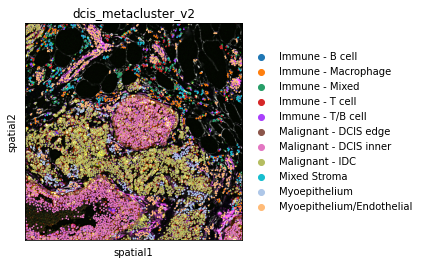

In [42]:
sc.pl.spatial(adata, color='dcis_metacluster_v2', crop_coord=[5000, 7000, 5000, 7000], size=.8)

In [56]:
sq.gr.interaction_matrix(adata, cluster_key="dcis_metacluster_v2", normalized=True)

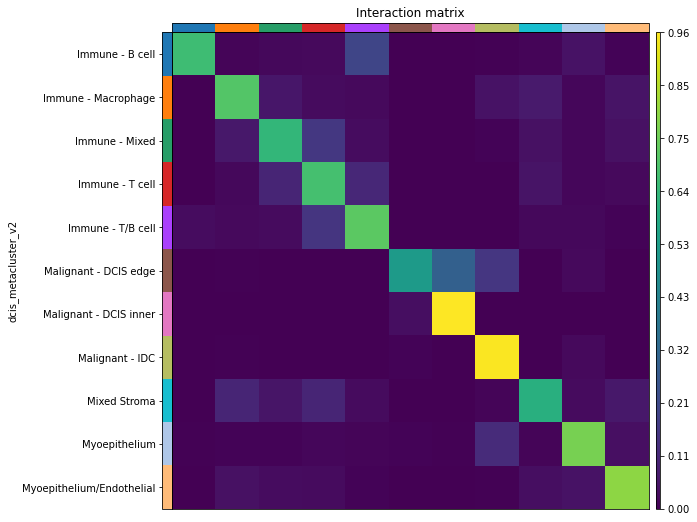

In [58]:
sq.pl.interaction_matrix(adata, cluster_key="dcis_metacluster_v2")

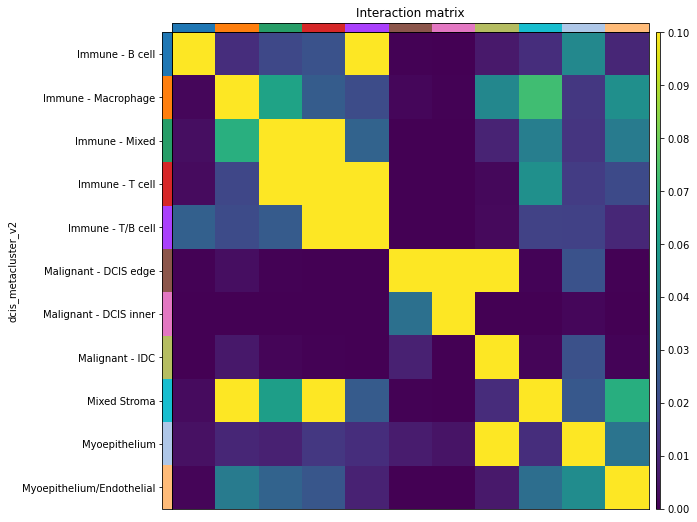

In [60]:
sq.pl.interaction_matrix(adata, cluster_key="dcis_metacluster_v2", vmax=.1)

In [80]:
sq.gr.co_occurrence(adata, cluster_key="dcis_metacluster_v2", n_splits=1, n_jobs=40)

  0%|          | 0/1 [00:00<?, ?/s]

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


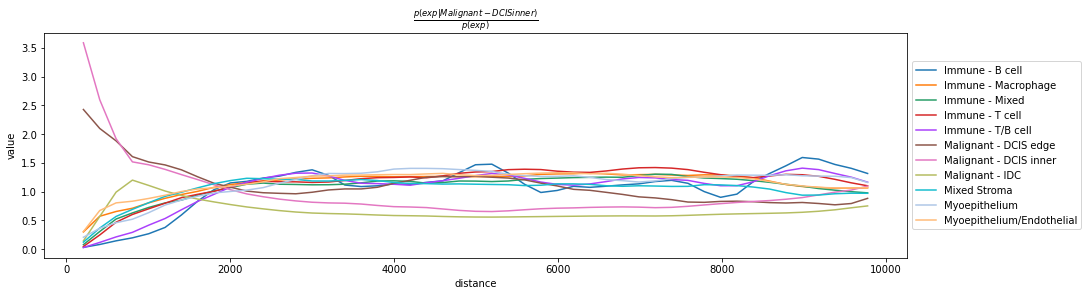

In [81]:
sq.pl.co_occurrence(
    adata,
    cluster_key="dcis_metacluster_v2",
    clusters=["Malignant - DCIS inner"],
    figsize=(15, 4),
)

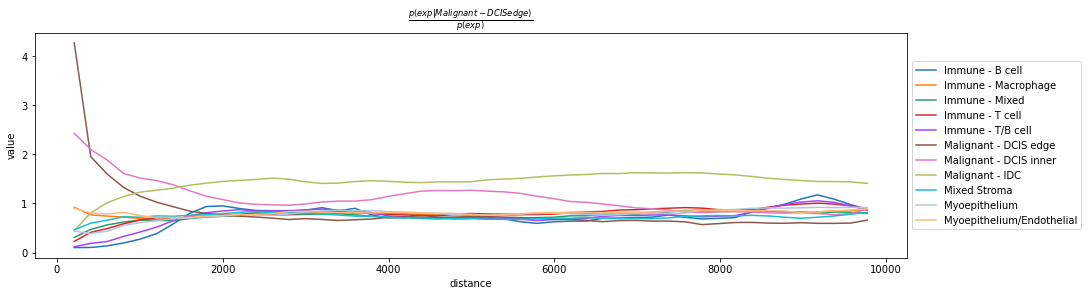

In [82]:
sq.pl.co_occurrence(
    adata,
    cluster_key="dcis_metacluster_v2",
    clusters=["Malignant - DCIS edge"],
    figsize=(15, 4),
)

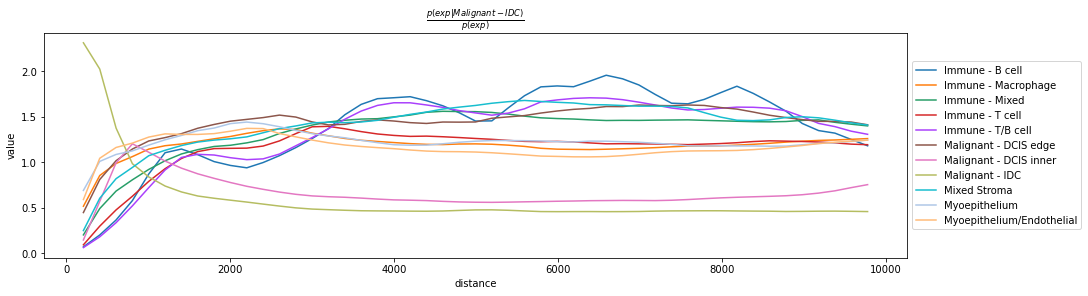

In [83]:
sq.pl.co_occurrence(
    adata,
    cluster_key="dcis_metacluster_v2",
    clusters=["Malignant - IDC"],
    figsize=(15, 4),
)

In [84]:
adata.write_h5ad('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/HT206B1-H1/downstream_analysis/dcis_analysis.h5ad')